# Event Segmentation Plots

This script loads in the event segmentation data, organizes it into a DataFrame, and generates:  
1. Raster plots ("spikes" corresponding to  participant marks)
2. KDE plots representing the "spike" distributions
3. A summary output containing the # raters and # events per walk

> Author:    Justin Campbell    
> Contact:   justin.campbell@hsc.utah.edu     
> Version:   01-20-2022     

## 1. Import Libraries

In [1]:
import os
import glob
import datetime
import statistics
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns

In [2]:
# check whether running locally (.ipynb) vs. Google Colab
try:
    from google.colab import drive 
    drive.mount('/content/drive')
    print('Running via Colab...')
    ColabFlag = 1
except:
    print('Running Locally...')
    ColabFlag = 0

Mounted at /content/drive
Running via Colab...


## 2. Load & Clean ES Data

**If running via Google Colab, you first need to upload the data to the session drive:**  
1. Click the folder icon on the left sidebar
2. Click the file icon (Upload to session storage)
3. Locate the folder of .csv files (`.../Box/INMANLab/Data/EventSeg/`)
4. Highlight all .csv files (shift+click) and upload

The script will outpute the number of .csv files found.

In [3]:
if ColabFlag:
  datapath = '/content/'
  files = glob.glob(os.path.join(datapath, '*Event_Perception*.csv'))
  print('Found %i files' %(len(files)))

else:
  datapath = '/Users/justincampbell/Desktop/EventSeg/'
  files = glob.glob(os.path.join(datapath, '*Event_Perception*.csv'))
  print('Found %i files' %(len(files)))

Found 166 files


The function `ESFileCleaner()` loads in the raw .csv files and organizes the data into a Pandas DataFrame.

In [5]:
def ESFileCleaner(filepath):
    # this function prepares the raw .csv file for plotting / analysis

    # load data
    df = pd.read_csv(filepath)

    # pull key info
    try:
      pID = df['participant'].unique()
      videos = df['movie_filename'].unique()
      RT1 = df['resp1.rt'].unique()
      RT2 = df['resp2.rt'].unique()
      RT3 = df['resp3.rt'].unique()
      Age = df['age'].unique()
      Sex = df['sex'].unique()  
      

      # remove empty rows
      pID = pID[~pd.isnull(pID)][0]
      videos = videos[~pd.isnull(videos)]
      RT1 = RT1[~pd.isnull(RT1)][0]
      RT2 = RT2[~pd.isnull(RT2)][0]
      RT3 = RT3[~pd.isnull(RT3)][0]
      Age = Age[~pd.isnull(Age)][0]
      Sex = Sex[~pd.isnull(Sex)][0]

      # clean-up video names
      videos = [x.split('/')[1] for x in videos]
      videos = [x.split('.')[0] for x in videos]

      # parse video details
      pIDNum = pID[2:]
      pIDNum = pIDNum.replace('O','0')
      pIDNum = int(pIDNum)
      RWNum = [x.split('_')[0][-1] for x in videos]
      walkNum = [x.split('_')[1] for x in videos]

      # clean-up RTs
      def RTCleaner(RT):
          # this function fixes formatting issues from loading the .csv file
          RT = RT.replace('[','')
          RT = RT.replace(']','')
          RT = RT.replace(' ', '')
          RT = RT.split(',')
          RT = np.array(RT)
          RT = [float(x) for x in RT]
          return RT

      RT1 = RTCleaner(RT1)
      RT2 = RTCleaner(RT2)
      RT3 = RTCleaner(RT3)

      # export to table
      TABLElen = len([videos[0]] * len(RT1) + [videos[1]] * len(RT2) + [videos[2]] * len(RT3))

      ESTable = pd.DataFrame(data = {'pID': ([pID] * TABLElen), 
                                  'pIDNum': ([pIDNum] * TABLElen), 
                                  'Video': ([videos[0]] * len(RT1) + [videos[1]] * len(RT2) + [videos[2]] * len(RT3)), 
                                  'RWN': ([RWNum[0]] * len(RT1) + [RWNum[1]] * len(RT2) + [RWNum[2]] * len(RT3)), 
                                  'Walk': ([walkNum[0]] * len(RT1) + [walkNum[1]] * len(RT2) + [walkNum[2]] * len(RT3)), 
                                  'Event': np.concatenate([RT1,RT2,RT3])})

      # fix variable types
      ESTable['pIDNum'] = pd.to_numeric(ESTable['pIDNum'])
      ESTable['RWN'] = pd.to_numeric(ESTable['RWN'])
      ESTable['Walk'] = pd.to_numeric(ESTable['Walk'])
      ESTable['Event'] = pd.to_numeric(ESTable['Event'])
      ESTable['Event'] = ESTable['Event'] / 60 # convert to minutes

      # reset index
      ESTable = ESTable.reset_index(drop=True)
    
    except:
      path, file = os.path.split(filepath)
      print('Could not process %s...' %file)
      return
    
    return ESTable

In [6]:
ESTable = pd.concat([ESFileCleaner(file) for file in files])

Could not process ES072_Event_Perception_test_2022-11-17_15h03.44.csv...
Could not process ES268_Event_Perception_test_2023-01-27_13h00.04.766.csv...
Could not process ES187_Event_Perception_test_2022-12-08_15h01.38.csv...
Could not process ES129_Event_Perception_test_2022-11-29_14h02.56.667.csv...
Could not process ES087_Event_Perception_test_2022-11-28_11h58.30.364.csv...
Could not process ES028_Event_Perception_test_2022-11-07_11h56.12.768.csv...
Could not process ES100_Event_Perception_test_2022-11-21_12h04.22.388.csv...
Could not process ES174_Event_Perception_test_2022-12-06_14h02.46.csv...


## 3. Generate ES Plots

In [9]:
# Plot styling
plt.rcParams["font.weight"] = "bold"
plt.rcParams["axes.labelweight"] = "bold"
plt.rcParams["axes.titleweight"] = "bold"
plt.rcParams["axes.titlesize"] = 20
plt.rcParams["font.family"] = "sans-serif"
sns.set_palette('crest')
histColor = sns.color_palette('crest_r', 5)[1]

The function `genRasterHist` generates a summary figure for each RNS patient, which consists of the "raster plots" of event times, and their associated histograms.

In [10]:
def genRasterHist(pID, walk = False, save = False):

  if walk == False:
    # Initialize figure
    fig = plt.figure(figsize = (20,10))
    
    # Define grid spec
    height_ratios = [1,.5,.5,1,.5]
    gs = gridspec.GridSpec(ncols=4, nrows=5, wspace = 0.25, figure=fig, height_ratios = height_ratios)
    ax1A = fig.add_subplot(gs[0,0])
    ax2A = fig.add_subplot(gs[0,1], sharey = ax1A)
    ax3A = fig.add_subplot(gs[0,2], sharey = ax1A)
    ax4A = fig.add_subplot(gs[0,3], sharey = ax1A)
    ax5A = fig.add_subplot(gs[3,0], sharey = ax1A)
    ax6A = fig.add_subplot(gs[3,1], sharey = ax1A)
    ax7A = fig.add_subplot(gs[3,2], sharey = ax1A)
    ax1B = fig.add_subplot(gs[1,0], sharex = ax1A)
    ax2B = fig.add_subplot(gs[1,1], sharey = ax1B, sharex = ax2A)
    ax3B = fig.add_subplot(gs[1,2], sharey = ax1B, sharex = ax3A)
    ax4B = fig.add_subplot(gs[1,3], sharey = ax1B, sharex = ax4A)
    ax5B = fig.add_subplot(gs[4,0], sharey = ax1B, sharex = ax5A)
    ax6B = fig.add_subplot(gs[4,1], sharey = ax1B, sharex = ax6A)
    ax7B = fig.add_subplot(gs[4,2], sharey = ax1B, sharex = ax7A)
    ax8A = fig.add_subplot(gs[3:,3])

    # Filter data
    df = ESTable[ESTable['RWN'] == int(pID[-1])].copy()
    tMax = int(np.ceil(df['Event'].max()))

    # Dicts for summary data
    nRaters = {}
    nEvents = {}

    # Rasters
    for i, ax in enumerate([ax1A, ax2A, ax3A, ax4A, ax5A, ax6A, ax7A]):
      walkDF = df[df['Walk'] == (i+1)].copy().reset_index(drop = True)
      nRaters[(i+1)] = len(walkDF['pID'].unique())
      nEvents[(i+1)] = walkDF.shape[0]
      if not walkDF.empty:
        rasterEvents = []
        for ii in walkDF['pID'].unique():
          pWalkDF = walkDF[walkDF['pID'] == ii]
          rasterEvents.append(pWalkDF['Event'].values)
        ax.eventplot(rasterEvents, linelengths = 0.75, linewidths = 2, lineoffsets = 1, colors = sns.color_palette('crest', len(rasterEvents)))

    # Histograms / KDEs
    bins = 40
    for i, ax in enumerate([ax1B, ax2B, ax3B, ax4B, ax5B, ax6B, ax7B]):
      walkDF = df[df['Walk'] == (i+1)].copy().reset_index(drop = True)
      if not walkDF.empty:
        sns.histplot(data = walkDF, x = 'Event', binrange = [0,tMax], binwidth = 1, color = histColor, ax = ax)
        
    # Clean-up appearance
    fig.suptitle('%s' %(pID), fontsize = 30, fontweight = 'bold')
    sns.despine(top = True, right = True)
    for i, ax in enumerate([ax1A, ax2A, ax3A, ax4A, ax5A, ax6A, ax7A]):
      ax.set_title('Walk ' + str(i+1) + '\n(n = %s)' %nRaters[(i+1)])
      plt.setp(ax.get_xticklabels(), visible=False)
      ax.set_ylabel('Rater', fontsize = 15)
      ax.set_yticklabels([])
    for ax in [ax1B, ax2B, ax3B, ax4B, ax5B, ax6B, ax7B]:
      ax.set_xlabel('Time (min)', fontsize = 15)
      ax.set_ylabel('Events', fontsize = 15)
      ax.set_xlim([0,tMax+0.1])
      ax.set_xticks(np.arange(0,tMax,2))
      ax.locator_params(axis='x', nbins=12)
    ax8A.set_title('Summary')
    ax8A.axis('off')

    # Add summary
    # ax8A.text(0, 0.75, '# Walks: %i' %(len(ESTable['Walk'].unique())), fontsize = 15)
    ax8A.text(0, 0.75, '# Raters: %i - %i (%.2f $\pm$ %.2f)' %(min(nRaters.values()),max(nRaters.values()),statistics.mean(nRaters.values()),statistics.stdev(nRaters.values())), fontsize = 15)
    ax8A.text(0, 0.55, '# Events: %i - %i (%.2f $\pm$ %.2f)' %(min(nEvents.values()),max(nEvents.values()),statistics.mean(nEvents.values()),statistics.stdev(nEvents.values())), fontsize = 15)

    if save == True:
      save_str = pID + '_ESPlots.pdf'
      plt.savefig(os.path.join(datapath, save_str), dpi = 600, bbox_inches = 'tight')

  if walk != False:
    # Initialize figure
    fig = plt.figure(figsize = (30,10))
    
    # Define grid spec
    height_ratios = [1,.5]
    gs = gridspec.GridSpec(ncols=1, nrows=2, wspace = 0.25, figure=fig, height_ratios = height_ratios)
    axA = fig.add_subplot(gs[0,0]) # Raster
    axB = fig.add_subplot(gs[1,0], sharex = axA) # KDE
    
    # Filter data
    df = ESTable[ESTable['RWN'] == int(pID[-1])].copy()
    walkDF = df[df['Walk'] == walk].copy().reset_index(drop = True)
    walkDF['Event'] = walkDF['Event'] * 60 # convert to seconds
    tMax = np.ceil(walkDF['Event'].max() / 10) * 10

    # Dicts for summary data
    nRaters = {}
    nEvents = {}

    # Raster & KDE
    if not walkDF.empty:
      rasterEvents = []
      for ii in walkDF['pID'].unique():
        nRaters = len(walkDF['pID'].unique())
        pWalkDF = walkDF[walkDF['pID'] == ii]
        rasterEvents.append(pWalkDF['Event'].values)
      axA.eventplot(rasterEvents, linelengths = 0.75, linewidths = 2, lineoffsets = 1, colors = sns.color_palette('crest', len(rasterEvents)))
      sns.histplot(data = walkDF, x = 'Event', binrange = [0,tMax], binwidth = 10, color = histColor, ax = axB)
      
    # Clean-up appearance
    fig.suptitle(('%s' + ' - Walk %s') %(pID, walk), fontsize = 30, fontweight = 'bold')
    sns.despine(top = True, right = True)
    axA.set_title('(n = %s)' %nRaters)
    plt.setp(axA.get_xticklabels(), visible=False)
    axA.set_ylabel('Rater', fontsize = 15)
    axA.set_yticklabels([])
    axB.set_xlabel('Time (sec)', fontsize = 15)
    axB.set_ylabel('Events', fontsize = 15)
    axB.set_xlim([0,tMax+1])
    plt.locator_params(axis='x', nbins=160)
    plt.xticks(rotation=45)
      
    if save == True:
      save_str = pID + '_' + str(walk) + '_ESPlots.pdf'
      plt.savefig(os.path.join(datapath, save_str), dpi = 600, bbox_inches = 'tight')

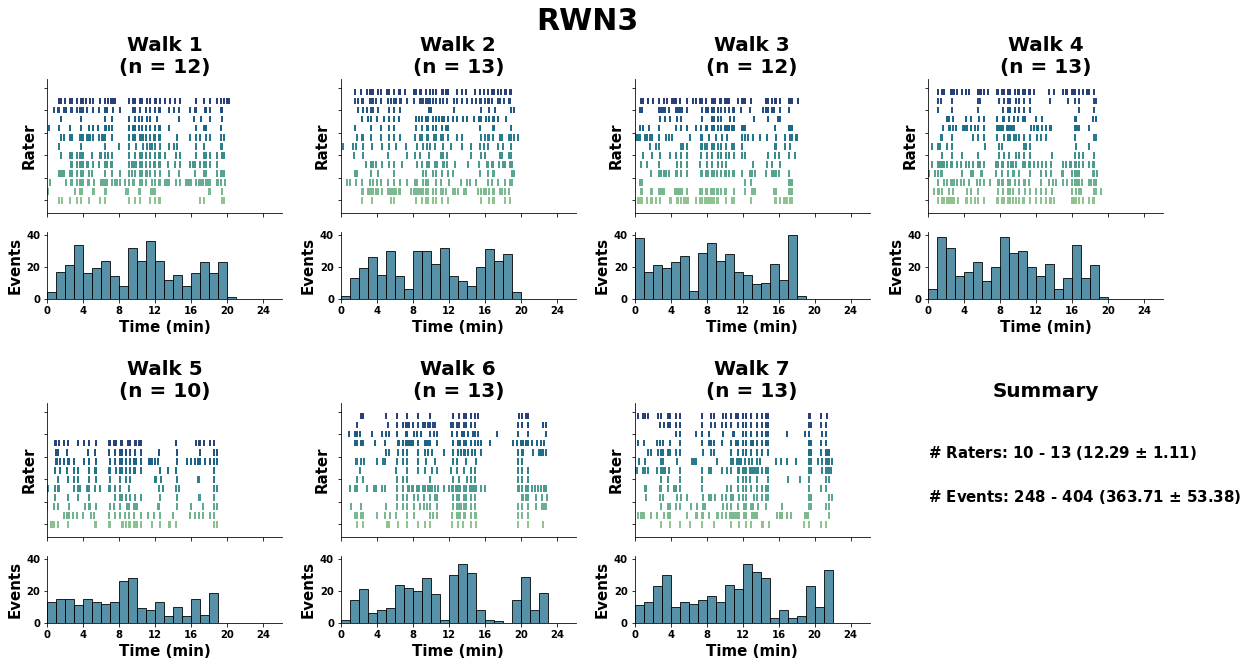

In [11]:
# Summary for one patient:
genRasterHist('RWN3', save = False) 

# Summary for all patients:
# for i in ESTable['RWN'].unique():
#     RWNstr = 'RWN' + str(i)
#     genRasterHist(RWNstr, save = False)

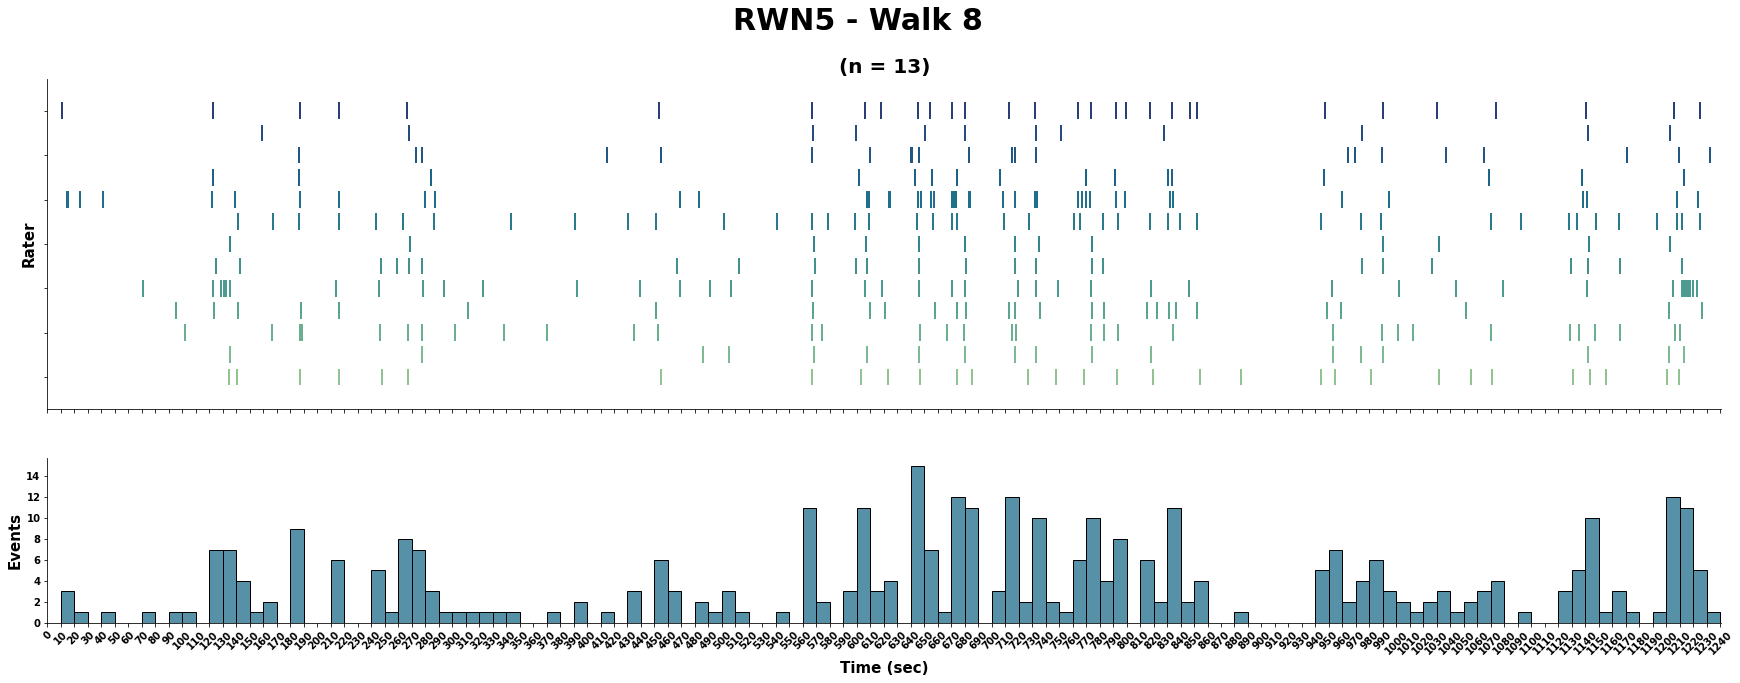

In [47]:
# Run for one video
genRasterHist('RWN5', walk = 8, save = False)

In [12]:
print = 'Age'